# Ising models and Metropolis algorithm

:::{admonition} **What you will learn**

- Ising models are minimal models used to phase transitions. 
- The Ising model is defined by a Hamiltonian that encodes both the interaction between neighboring spins $i$ and $j$ (for nearest neighbors, $|i - j| = 1$), and the interaction of spins with an external field $B$:
- Markov Chain Monte Carlo (MCMC) presents an straightforward and affordable way of simulating ising models. 
- The particularly simple and efficient formulation of MCMC for ising models is given by Metropolis selection criteria. 
:::


### Hamiltonian of a 2D Ising model

:::{admonition} **Ising Model**
:class: important

$${H([s]) = - \sum_{<ij>} J s_i s_j - h \sum_i s_i}$$

$${Z = \sum_{[s]} e^{-H([s])/k_B T}}$$

- Each spin variable takes values $s_i = \pm 1$
- $[s] = [s_1, s_2, \dots]$ denotes a microstate defined by the configuration of all spins  
- Parameters of the Ising model: $h$ is the external magnetic field, and $J$ is the spin–spin coupling strength  
- The summation $<ij>$ is over **nearest-neighbor** spin pairs

:::

### Extracting thermodynamics from Ising models

- We can compute thermodynamic quantities from spin configurations generated during Ising model simulations. 

- One key observable is the total or per spin **magnetization**, which measures the net alignment of spins.

$$M([s]) = \sum_i s_i$$

$$m([s]) = \frac{1}{N} \sum_i s_i = \frac{M}{N}$$

- We can calculate probability of macrostate defined to include all spin configurations with a fixed value of magnetization $M$.

$$P(M) = \frac{Z(M)}{Z} = \frac{\sum_{[s]} e^{-\beta H([s])} \, \delta(M - M([s]))}{Z}$$

- From this, we can compute the **free energy** as a function of magnetization $M$

$$F(M) = -\beta^{-1} \log Z(M) + const$$

- This magnetization-dependent free energy tells us about the relative stability and likelihood of different magnetization states in the system. Near phase transitions, $F(M)$ may develop multiple minima, corresponding to coexisting phases.


### Extracting Response functions 

To quantify **fluctuations** in energy and magnetization, we compute the following **response functions**:

- **Heat capacity**, $C_V$, measures energy fluctuations:

$$C_V(T) = \left( \frac{\partial \langle E \rangle}{\partial T} \right)_V = \frac{1}{k_B T^2} \left( \langle E^2 \rangle - \langle E \rangle^2 \right)$$

- **Magnetic susceptibility**, $\chi_T$, measures magnetization fluctuations in response to an external field $B$:

$$\chi_T = \left( \frac{\partial \langle M \rangle}{\partial B} \right)_T = \frac{1}{k_B T} \left( \langle M^2 \rangle - \langle M \rangle^2 \right)$$

These response functions become particularly important near critical points, where fluctuations are enhanced, and $C_V$ and $\chi_T$ may diverge in the thermodynamic limit.


### Setting up the spin lattice 

[[ 1 -1  1 -1 -1  1 -1  1]
 [ 1  1 -1 -1  1 -1 -1 -1]
 [ 1 -1 -1 -1  1  1  1 -1]
 [-1 -1  1  1 -1  1  1 -1]
 [-1 -1 -1 -1  1 -1  1  1]
 [ 1  1 -1  1 -1  1 -1 -1]
 [ 1  1 -1  1  1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1  1]]


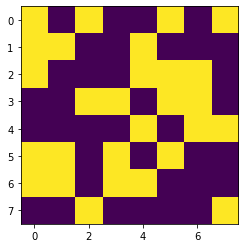

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spins = np.random.choice([-1,1],size=(8,8))

print(spins)

plt.imshow(spins)

### Enforcing periodic boundary conditions

- In the **Ising model with periodic boundary conditions**, the **modulo operation** is used to wrap around the edges of the lattice—so that spins on one edge interact with those on the opposite edge. 
- This effectively turns a 2D grid into a torus (doughnut shape), avoiding edge effects and mimicking an infinite system.

- Consider a 2D lattice of size $ L \times L $. For a site at position $ (i, j) $, its **right neighbor** is at $ (i, j+1) $. But if $ j = L - 1 $, then $ j+1 $ exceeds the lattice. To **wrap around**, we use:

$$
j_{\text{right}} = (j + 1) \mod L
$$

- This brings the index back to $ 0 $ when it exceeds $ L - 1 $.


In [ ]:
L = 10  # Lattice size
spins = np.random.choice([-1,1], size=(L, L))

i, j = 3, 9  # Current spin

# Neighbors with periodic boundary conditions
right = spins[i][(j + 1) % L]
left  = spins[i][(j - 1) % L]
up    = spins[(i - 1) % L][j]
down  = spins[(i + 1) % L][j]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a color map: default to gray, highlight tagged spin and neighbors
color_map = np.full((L, L), 0.5)  # Gray background

# Highlight neighbors (green) and tagged spin (red)
color_map[i, j] = 1.0  # Red for the tagged spin

color_map[i, (j + 1) % L] = 0.2  # Green-ish
color_map[i, (j - 1) % L] = 0.2
color_map[(i - 1) % L, j] = 0.2
color_map[(i + 1) % L, j] = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(color_map, cmap="coolwarm", origin="upper", vmin=0, vmax=1)

# Overlay spin values
for x in range(L):
    for y in range(L):
        spin = spins[x, y]
        ax.text(y, x, f"{spin}", ha='center', va='center', color='black', fontsize=10)

# Grid and labels
ax.set_xticks(np.arange(L))
ax.set_yticks(np.arange(L))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title(f"Tagged spin at ({i}, {j}) and its neighbors", fontsize=12)
ax.grid(False)

plt.tight_layout()
plt.show()


In [ ]:
def get_dE(spins, i, j, J=1, B=0):
    '''Compute change in energy of 2D spin lattice 
    after flipping a spin at a location (i,j)''' 
    
    N = len(spins)
    
    z  = spins[(i+1)%N, j] + spins[(i-1)%N, j] + \
             spins[i, (j+1)%N] + spins[i, (j-1)%N] 
             
    dE = 2*spins[i,j]*(J*z + B)
    
    return dE

### Sampling Boltzmann distribution: MC vs MCMC

- **Monte Carlo** appraoch to computing observables is simple: all we have to do is sample from the exponential distribution.

$$P(E_i)= \frac{e^{-\beta E_i}}{\sum_i e^{-\beta E_i}}$$

$$\langle A\rangle = \sum_i A_iP(E_i) \approx\frac{1}{N}\sum_{i=1}^N \underbrace{A_i}_{{\rm chosen}\ {\rm acc.}\ {\rm to}\ P(E_i)}$$

- **Problems with MC**
    - There is an astronomical number of states, $i = 1... N^2$! 
    - Most of these microstates make exponentially small contribution to probability distribution! $P(E_i)$
    - Brute force MC will not be efficient for sampling important portions of $P(E_i)$.


### Generating chains! Master Equation and Detailed Balance

**Random chain**

- In simple MC each sampled state $X_i$ at step $i$ is independet of the next or previous steps. 

- Thus, MC sampling generates totally uncorrelated samples which is good for rapid convergence according to Central Limit Theorem. But as we remarked above the samples are most likely not covering important areas!

$$P(X_N, ..., X_2, X_1) = P_N(X_N)\cdot ... P_2(X_2) \cdot P_1(X_1)$$

**Markov chain:**

- In simple MCMC each sampled state $X_i$ at steo $i$ is generated from $i-1$.
- This introduces correlations between samples which means slower covnergence to the mean.
- On the other hand MCMC find the important areas for sampling much faster so in the hand it wins big compared to MC.

$$P(X_N, ..., X_2, X_1) = P_N(X_N)\cdot ... P_3(X_3| X_2) \cdot P_2(X_2| X_1)... P_1(X_1)$$


- The probability of picking state $i+1$ given taht we started from $i$ is referred to as **transition probability** $T_{ij}$ 

$$T_{21} = T(X_2 \leftarrow X_1) = P(X_2|X_1)$$

- As a probability it should be normalized:

$$\sum_{X} T_{XX'} = 1$$

- Probability of being at $X$ at $t+\Delta t$ given a prior state at $(X',t)$ can be written in terms of $T_{XX'}$ as:

$$P(X, t+\Delta t) = \sum_{X'}  T_{XX'} P(X', t)$$

- Subtracting P(X,t) from both states we can obtain equation of motion for Markov chain.

$$P(X, t+\Delta t) -P(X,t)= \sum_{X'}  T_{XX'} P(X', t) - P(X, t)\sum_{X'} T_{X'X}$$

- Defining **transition rates** as the limit of $w_{X'X} = lim_{\Delta t \rightarrow 0}\frac{T_{X'X} (\Delta t)}{\Delta t}$ we arrive at the master equation"

:::{admonition} **Master equation: A continuity equation in probability space.**
:class: important

$$\frac{\partial P(X,t)}{\partial t} = \sum_{X'}  w_{X X'} P(X', t) - \sum_{X'} w_{X' X} P(X, t)$$



:::


From maset equation we see that in order to reach equilibrium probability must stop depending on time. There are two possibilities:


$$\frac{\partial P(X,t)}{\partial t}  = \sum_{X'} P(X', t) w_{XX'} - \sum_{X'} P(X, t) w_{X' X}=0$$

- When the sum is equl zero becasue influx and outflux of probabiity currents cancel each out. This corresponds to steady state condition and is not true equilbroum for there are macroscopic fluxes in the system.
- When every single pairs is identically zero, this is known as detailed balance condition which is equivalent to thermodynamic equilibrium. 



:::{admonition} **Detailed Balance $\equiv$ Condition for equilibrium**

$${  w_{ij}\cdot p_j =  w_{ji} \cdot p_i  }$$

:::

**Master equation for a two state dynamics**

$$\frac{dP(x_1,t)}{dt} = w_{12} p_2 - w_{21} p_1$$

$$\frac{dP(x_2,t)}{dt} = w_{21} p_1  -  w_{12} p_2$$

- In the equilibrium we see that equilibrium is established when probability ratio matches the ratio of tranistions $\frac{p_1}{p_2} = \frac{w_{12}}{w_{21}}$
- In the $NVT$ ensemble we have an explicit requirment for transition rates $\frac{p_1}{p_2} = e^{-\beta (E_1-E_2)} = \frac{w_{12}}{w_{21}}$

### How to pick the moves for Markov chain?

- Now it is time to consider practical aspects of conducting MCMC. How to pick states and transitions?

$$[transition] =  [accept/reject] \cdot [move]$$

$$T(X' \leftarrow X) = \alpha_{X' X}\cdot A_{X' X} $$

- We have great freedom in picking states and moves as long as we satisfy the detailed balance! E.g as long as the ratio of transition probabilities matches ration of Botlzman factors!

- The simplest case for move is to pick one spins at random per iteration:

$$\alpha_{X' X} = \frac{1}{L^2}$$ 

- For transitions we adopt criteria that favors our chain to explore low energy (high probability) configurations:

- If $p(X') < p(X),\,\,\,\,$ $A_{X'X}=\frac{p(X')}{p(X)}$
- If $p(X') \geq p(X),\,\,\,$ $A_{X'X}=1$

$$\frac{T_{X'X}}{T_{XX'}} = \frac{1/L^2}{1/L^2} \cdot \frac{p(X')/p(X)}{1}$$

:::{admonition} **Metropolis algorithm**
:class: tip


**${ i. \ Initialization.}$**  
Generate an initial spin configuration $[s_0] = (s_1, \dots, s_N)$, either by assigning all spins the same value or choosing each spin randomly as $ +1 $ or $ -1 $.

**${ ii. \ Attempt\ spin\ flip.}$**  
Randomly select a spin and flip it (i.e., multiply by $-1$). This produces a trial configuration $[s_1]$.



**${iii. \ Accept/Reject\ move.}$**  
Compute the energy difference between the trial and original configurations:  

$$\Delta E = E_1 - E_0$$

Determine the acceptance probability:  

$$w = \frac{P[s_1]}{P[s_0]} = \exp(-\beta \Delta E)$$

Generate a random number $ r \in [0, 1] $ and apply the Metropolis criterion:

- **(a)** If $ r \leq w $, accept the move: set $ [s_0] \leftarrow [s_1] $
- **(b)** If $ r > w $, reject the move: retain $ [s_0] $

Return to step **ii** to continue sampling.

:::

### Code for running 2D ising MCMC Simulations

- If numba is installed, uncomment to benfit from jit acceleration!
- To speed benchmarks to assess how long simulation would take

In [ ]:
from numba import njit
import numpy as np

@njit
def run_ising2d(N, T, J, B, n_steps, out_freq):
    '''
    Metropolis Monte Carlo simulation of 2D Ising model.

    Parameters:
    N        : Lattice size (N x N)
    T, J, B  : Temperature, coupling constant, external field
    n_steps  : Number of Monte Carlo steps
    out_freq : Interval for recording observables

    Returns:
    S : List of 2D spin configurations
    E : List of per-spin energies
    M : List of per-spin magnetizations
    '''
    
    # Initialize spin lattice
    spins = 2 * (np.random.rand(N, N) < 0.5) - 1
    M_t   = np.sum(spins)
    E_t   = -B * M_t

    for i in range(N):
        for j in range(N):
            
            neighbors = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N]
            E_t += -0.5 * J * spins[i, j] * neighbors

    # Lists to store observables
    S, E, M = [], [], []

    for step in range(n_steps):

        i, j = np.random.randint(N), np.random.randint(N)
        neighbors = spins[(i+1)%N, j] + spins[(i-1)%N, j] + spins[i, (j+1)%N] + spins[i, (j-1)%N]
        dE = 2 * spins[i, j] * (J * neighbors + B)
        dM = 2 * spins[i, j]

        if np.random.rand() < np.exp(-dE / T):
            spins[i, j] *= -1
            E_t += dE
            M_t += dM

        if step % out_freq == 0:
            E.append(E_t / N**2)
            M.append(M_t / N**2)
            S.append(spins.copy())

    return S, E, M

In [160]:
#Simulation Parameters
params = {'N':40,
          'J':1,
          'B':0, 
          'T': 4,
          'n_steps': 100000, 
          'out_freq': 10}

# Simulation
S, E, M = run_ising2d(**params)

In [158]:
np.array(S).shape, np.array(E).shape, np.array(M).shape

((1000, 40, 40), (1000,), (1000,))

### Visualize MCMC simulations

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#@widgets.interact(i=(0, 10000-1))
def plot_image(i=0):
    
    fig, ax  = plt.subplots(ncols=3, figsize=(10,4))
    
    ax[0].pcolor(S[i])
    ax[1].plot(E)
    ax[2].plot(M)
    
    ax[0].set(ylabel='$i$', xlabel='j')
    ax[1].set(ylabel='$E$', xlabel='steps')
    ax[2].set(ylabel='$M$', xlabel='steps')
    fig.tight_layout()
    plt.show()



def make_html_animation(S, E, M, interval=100):
    fig, ax = plt.subplots(ncols=3, figsize=(10, 4))

    # Initial plots
    im = ax[0].imshow(S[0], cmap='coolwarm', origin='lower')
    e_line, = ax[1].plot([], [], lw=2)
    m_line, = ax[2].plot([], [], lw=2)

    # Axis labels
    ax[0].set_title("Spin Configuration")
    ax[1].set_title("Energy")
    ax[2].set_title("Magnetization")

    ax[0].set(xlabel="j", ylabel="i")
    ax[1].set(xlabel="Steps", ylabel="E")
    ax[2].set(xlabel="Steps", ylabel="M")

    ax[1].set_xlim(0, len(E))
    ax[1].set_ylim(min(E), max(E))
    ax[2].set_xlim(0, len(M))
    ax[2].set_ylim(min(M), max(M))

    def update(frame):
        im.set_array(S[frame])
        e_line.set_data(range(frame + 1), E[:frame + 1])
        m_line.set_data(range(frame + 1), M[:frame + 1])
        return im, e_line, m_line

    anim = FuncAnimation(fig, update, frames=len(S), interval=interval, blit=False)
    plt.close(fig)  # Avoid double display in Jupyter

    return HTML(anim.to_jshtml())  # Or anim.to_html5_video()


In [ ]:

make_html_animation(S, E, M)

### Carry out explorative simulations

- How do we know if the simulation has done enough sampling? How do we assess convergence and errors? 
- Test the dependence of observables on system size.
- Test the dependence of observables on initital conditions.
- Vary intensive parameters, e.g., temperature and field strength. Investigate changes in observables such as magnetization, energy, susceptibility, heat capacity.
- Think about alternative ways of accelerating and enhancing the sampling.

#### Parameter sweeps 

In [161]:
#Simulation Parameters
params = {'N':40,
          'J':1,
          'B':0, 
          'T': 4,
          'n_steps': 1000000, 
          'out_freq': 10}

Ts = np.linspace(1, 4, 40) 
Es, Ms, Cs, Xs = [], [], [], []  

for T in Ts:
    
    params['T']=T
    
    S, E, M = run_ising2d(**params)

    # Save last 90% percent of data
    idx = int(len(E) * 0.1) 
    
    E = E[idx:]
    M = M[idx:]
    
    Es.append(np.mean(E))
    Ms.append(np.mean(M))
    
    Cs.append(np.var(E)/T**2) 
    Xs.append(np.var(M)/T)

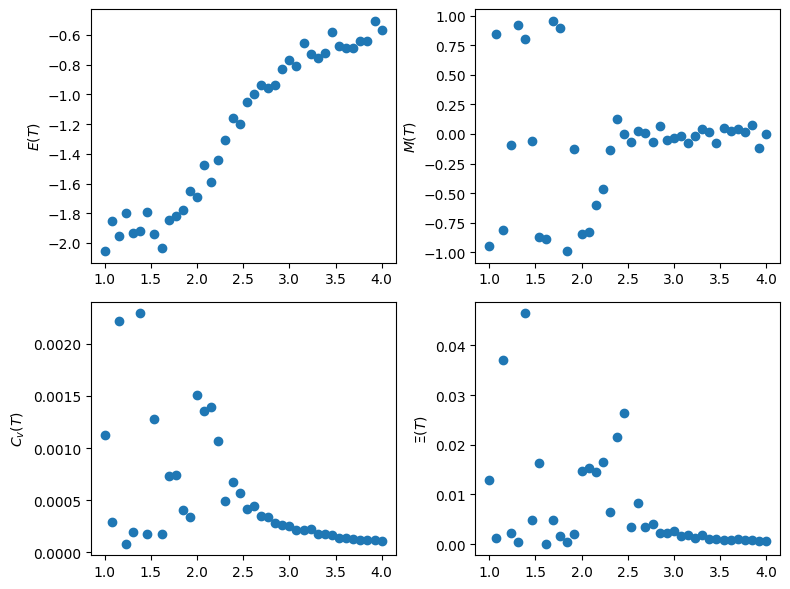

In [162]:
fig, ax  = plt.subplots(ncols=2, nrows=2, figsize=(8,6))

ax[0,0].scatter(Ts, Es)
ax[0,0].set(ylabel='$E(T)$')

ax[0,1].scatter(Ts, Ms)
ax[0,1].set(ylabel='$M(T)$')

ax[1,0].scatter(Ts, Cs)
ax[1,0].set(ylabel='$C_v(T)$')

ax[1,1].scatter(Ts, Xs)
ax[1,1].set(ylabel='$\Xi(T)$')
fig.tight_layout()

### Autocorrelation functions

- For any observable $ A(t) $, you can compute:

$$
C_A(n) = \langle A(t) A(t+n) \rangle - \langle A(t) \rangle^2
$$

- or the normalized version of autocorrelation funtion:

$$
\rho_A(n) = \frac{\langle A(t) A(t+n) \rangle - \langle A(t) \rangle^2}{\langle A(t)^2 \rangle - \langle A(t) \rangle^2}
$$


| Observable            | Type                  | Purpose                              |
|----------------------|-----------------------|--------------------------------------|
| $ M(t) $, $ E(t) $ | Global observables    | System-wide relaxation               |
| $ s_i s_{i+r} $      | Spatial correlation   | Correlation length / criticality     |
| $ C(n) $             | General ACF           | Basis for estimating correlation time|




#### Integrated and exponential autocorrelation time

- Once you compute $ C(n) $, you can also estimate:

- **Integrated autocorrelation time** $ \tau_{\text{int}} $:
  $$
  \tau_{\text{int}} = \frac{1}{2} + \sum_{n=1}^{n_{\text{cut}}} \frac{C(n)}{C(0)}
  $$

- **Exponential autocorrelation time** by fitting $ C(n) \sim \exp(-n / \tau_{\text{exp}}) $





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def autocorr(x):
    """
    Computes the normalized autocorrelation function of a 1D time series x.

    Parameters:
    x : array-like
        Time series (e.g., magnetization over MC steps)

    Returns:
    acf : array-like
        Autocorrelation function normalized so that acf[0] = 1
    """
    n = len(x)
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')[-n:]
    result /= x.var() * np.arange(n, 0, -1)
    return result

def exp_decay(n, a, tau):
    """Exponential decay model"""
    return a * np.exp(-n / tau)

def estimate_exp_autocorr_time(x, max_lag=100):
    """Estimate exponential autocorrelation time and effective sample size"""
    acf = autocorr(x)
    lags = np.arange(max_lag)

    # Fit exponential decay model to ACF
    try:
        popt, _ = curve_fit(exp_decay, lags, acf[:max_lag], p0=(1.0, 10.0))
        a, tau_exp = popt
    except RuntimeError:
        tau_exp = np.nan  # Fit failed

    # Compute effective sample size
    N_eff = len(x) / (2 * tau_exp) if tau_exp > 0 else np.nan

    # Plot
    plt.figure(figsize=(5, 3))
    plt.plot(lags, acf[:max_lag], label="Autocorrelation")
    plt.plot(lags, exp_decay(lags, *popt), '--', label=f"Fit: $\\tau_{{\\exp}}$ ≈ {tau_exp:.2f}")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return tau_exp, N_eff


In [ ]:
# Example usage
M = np.random.randn(1000)  # Replace with your magnetization time series
acorr = autocorr(M)

# Plotting
plt.plot(acorr / acorr[0])
plt.xlabel('Steps, $n$')
plt.ylabel(r'$\langle M(t) M(t+n) \rangle$')
plt.title('Autocorrelation of Magnetization')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Example usage:
x = np.random.randn(1000).cumsum()  # Strongly correlated data
tau_exp, N_eff = estimate_exp_autocorr_time(x)

print(f"Exponential autocorrelation time: {tau_exp:.2f}")
print(f"Effective sample size: {N_eff:.1f} (out of {len(x)} total samples)")

#### Spatial correlation functions

$$
C(r) = \langle s_i s_{i+r} \rangle
$$

- Gives insight into **correlation length** and spatial structure.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def spatial_autocorr(spins, axis=0):
    """
    Computes spatial autocorrelation function along specified axis (0 = rows, 1 = columns)
    
    Parameters:
    spins : 2D numpy array of spins (+1/-1)
    axis  : direction to compute correlation along (0 = x, 1 = y)

    Returns:
    corr : autocorrelation as a function of distance
    """
    N = spins.shape[axis]
    corr = np.zeros(N)
    mean = np.mean(spins)
    var = np.var(spins)

    for r in range(N):
        if axis == 0:
            product = spins * np.roll(spins, -r, axis=0)
        else:
            product = spins * np.roll(spins, -r, axis=1)

        corr[r] = np.mean(product) - mean**2
    return corr / var


In [ ]:
# Example usage:
spins = 2 * (np.random.rand(64, 64) < 0.5) - 1  # random config
corr_x = spatial_autocorr(spins, axis=0)
corr_y = spatial_autocorr(spins, axis=1)

# Plotting
plt.plot(corr_x, label='X direction')
plt.plot(corr_y, label='Y direction')
plt.xlabel('Distance $r$')
plt.ylabel('Spatial autocorrelation $C(r)$')
plt.legend()
plt.grid(True)
plt.title("Spatial autocorrelation in 2D Ising lattice")
plt.show()

### Problems

#### Problem-1

Revisit the example MCMC simulation for determining $\pi$ value. Vary the size of the displacement to determine the optimal size that generates quickest convergence to the value of $\pi$


#### Problem-2 

Carry out MC simulation of 2D ising spin model for various lattice sizes $N= 16,32, 64$ at temperatures above and below critical e.g $T<T_c$ and $T>T_c$.   

- How long does it take to equilibrate system as a function of size and as a function of T?

- Plot some observables as a function of number of samples states to show that the system is carrying out some sort of random walk in the configurational space. 

- How do profiles of Energy vs T, Magnetization vs T and heat capacity vs T, and susceptibility vs T change as a function of size of our lattice. 

- Does $J>0$ and $J<0$ change the nature of phase transition?

#### Problem-3

Compute correlation functions of spin variable, that is how correlated are spins as a function of distance on a lattice, $L$. $C(L)=\langle s_i s_{i+L}\rangle -\langle s_i\rangle \langle s_{i+L}\rangle $ Make sure to account for the periodic boundary conditions! 

> Note that you can pick a special tagged spin and calculate correlation function of taged spin ($s_13$ for instance) with any other as a function of lattice spearation  by averaging over produced MC configurations.  Or you can take advantage of the fact that there are no priviledged spins and average over many spins and average over MC configruations e.g $s_1, s_2, ...$. E.g you can pick a horizontal line of spins and run a summation for each fixed r_ab distance. 

#### Problem-4

Take a 20 by 20 lattice and equilibriate the system with a value of extneral field B equal to +1. 
Now slowly change h to −1 in discrete steps during each of these steps, use the previously equilibriated
configuration as an input to the system to undergo equilibriation again.  

Caluclate average and variance quantities (e.g E, M, C etc). Notice anything interesing :)